          Date   Returns
0   2010-01-01 -0.005522
1   2010-02-01  0.030901
2   2010-03-01 -0.001985
3   2010-04-01 -0.064877
4   2010-05-01 -0.015451
..         ...       ...
138 2021-07-01 -0.008640
139 2021-08-01 -0.032178
140 2021-09-01  0.057827
141 2021-10-01  0.010016
142 2021-11-01  0.016138

[143 rows x 2 columns]
0.3765042713937605


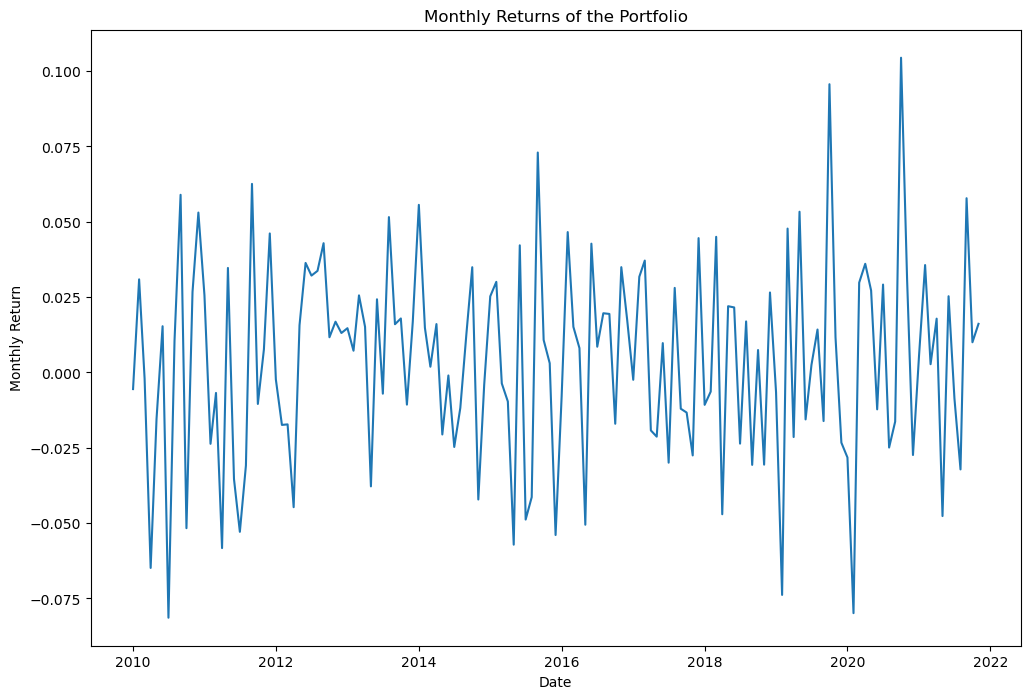

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip install arch
from arch import arch_model

# Load the data

prices = pd.read_csv('europe indices monthly.csv', delimiter=';', index_col='Date', parse_dates=True)
# Convert the columns with stock prices to numeric
prices['IBEX35'] = pd.to_numeric(prices['IBEX35'].str.replace(',', ''), errors='coerce')
prices['IT40'] = pd.to_numeric(prices['IT40'].str.replace(',', ''), errors='coerce')
prices['EUSTX50'] = pd.to_numeric(prices['EUSTX50'].str.replace(',', ''), errors='coerce')
prices['CAC40'] = pd.to_numeric(prices['CAC40'].str.replace(',', ''), errors='coerce')
prices['DAX'] = pd.to_numeric(prices['DAX'].str.replace(',', ''), errors='coerce')

# Calculate the returns and create a new DataFrame
returns = prices.pct_change().dropna()


# Set the weights
weights = np.full(len(prices.columns), 1/len(prices.columns))

# Set the initial investment and monthly investment
initial_investment = 100
monthly_investment = 100
target_investment = 14400

# Initialize the portfolio value with the initial investment
portfolio_value = [initial_investment]

# Initialize a list to store the corresponding dates
dates = []

# Iterate over the months and calculate the portfolio value
for i in range(len(prices) - 1):
    # Rebalance the portfolio every month
    if (i + 1) % 12 == 0:
        weights = np.full(len(prices.columns), 1/len(prices.columns))
    # Calculate the returns for the current month
    returns_current_month = returns.iloc[i]
    # Calculate the portfolio return for the current month
    portfolio_return = np.dot(weights, returns_current_month)
    # Calculate the portfolio value for the current month
    portfolio_value_month = portfolio_value[i] * (1 + portfolio_return)
    # Add the monthly investment to the portfolio value
    portfolio_value_month += monthly_investment
    # Add the portfolio value to the list of portfolio values
    portfolio_value.append(portfolio_value_month)
    # Record the date for this month
    dates.append(prices.index[i])

# Convert the list of portfolio values to a numpy array
portfolio_value = np.array(portfolio_value)
# Calculate the monthly returns
monthly_returns = ((portfolio_value[1:] - 100) / portfolio_value[:-1]) - 1
# Create a DataFrame with dates and monthly returns
df = pd.DataFrame({'Date': dates, 'Returns': monthly_returns})

# Add the portfolio value as a new column in the prices DataFrame
prices['Portfolio Value'] = portfolio_value

# Calculate the total return, volatility, and Sharpe ratio
total_return = (prices['Portfolio Value'].iloc[-1] / target_investment - 1)

cov_matrix = np.cov(returns.T)
portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights) * np.sqrt(12) * 100



# Print the DataFrame containing dates and returns
print(df)
print(total_return)
# Plot the monthly returns
plt.figure(figsize=(12, 8))
plt.plot(df['Date'], df['Returns'])
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.title('Monthly Returns of the Portfolio')
plt.show()

In [9]:
df22 = pd.DataFrame(monthly_returns, columns=['Returns'])

# Now 'df' is a DataFrame containing your array
print(df22)

      Returns
0   -0.005522
1    0.030901
2   -0.001985
3   -0.064877
4   -0.015451
..        ...
138 -0.008640
139 -0.032178
140  0.057827
141  0.010016
142  0.016138

[143 rows x 1 columns]


   Forecasted State  Forecasted Return
0   Positive Return           0.037297
1   Negative Return          -0.029044
2   Negative Return          -0.020421
3   Negative Return          -0.054154
4   Negative Return          -0.065516
5   Positive Return           0.024296
6   Positive Return           0.040114
7   Negative Return          -0.000279
8   Positive Return           0.049813
9   Positive Return           0.038039
10  Positive Return           0.000407
11  Positive Return           0.025974
12  Negative Return          -0.033305
13  Positive Return           0.038359
14  Positive Return           0.048539
15  Negative Return          -0.049482
16  Positive Return           0.003654
17  Positive Return           0.042192
18  Negative Return          -0.054082
19  Positive Return           0.025186
20  Positive Return           0.032649
21  Positive Return          -0.006586
22  Positive Return          -0.010076
23  Positive Return           0.041297
24  Positive Return      

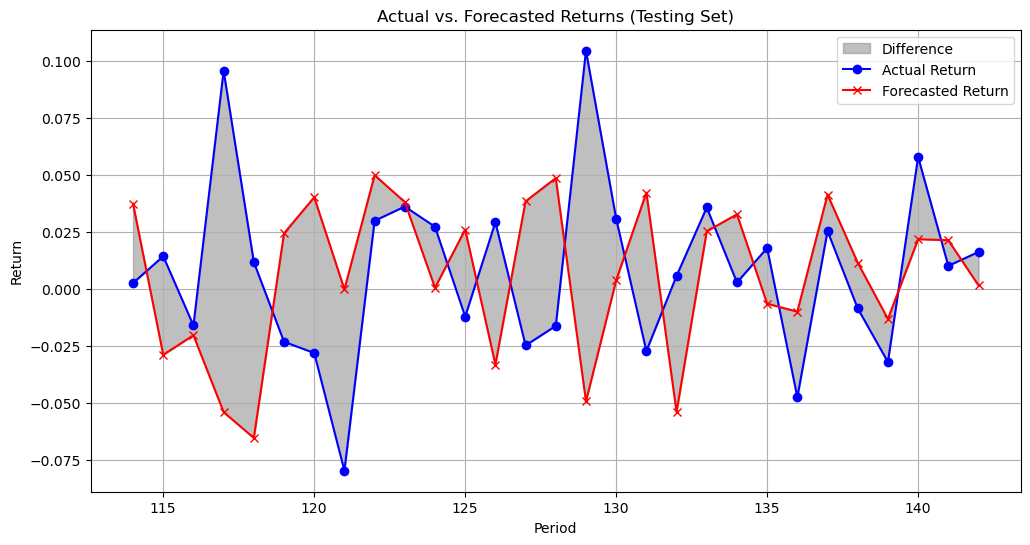

In [21]:
from sklearn.metrics import mean_absolute_error

# Define states
positive_state = "Positive Return"
negative_state = "Negative Return"

# Calculate transition probabilities
positive_to_positive = len(df[df['Returns'] > 0]) / len(df)
positive_to_negative = 1 - positive_to_positive
negative_to_negative = len(df[df['Returns'] <= 0]) / len(df)
negative_to_positive = 1 - negative_to_negative

# Create a transition matrix
transition_matrix = np.array([[positive_to_positive, positive_to_negative],
                               [negative_to_positive, negative_to_negative]])



# Initial state (assume starting in the last observed state)
current_state = positive_state if df['Returns'].iloc[-1] > 0 else negative_state

# Create lists to store forecasted states and returns
forecasted_states = []
forecasted_returns = []

# Simulate the Markov Chain to forecast future states and returns
for _ in range(forecast_periods):
    # Use the transition matrix to determine the next state's probabilities
    state_index = 0 if current_state == positive_state else 1
    state_probabilities = transition_matrix[state_index]

    # Sample the next state
    next_state_index = np.random.choice([0, 1], p=state_probabilities)
    next_state = [positive_state, negative_state][next_state_index]

    # Assign return values based on the state (add randomness)
    if next_state == positive_state:
        forecasted_return = np.random.normal(np.mean(df['Returns'][df['Returns'] > 0]), np.std(df['Returns'][df['Returns'] > 0]))
    else:
        forecasted_return = np.random.normal(np.mean(df['Returns'][df['Returns'] <= 0]), np.std(df['Returns'][df['Returns'] <= 0]))

    # Append the forecasted state and return
    forecasted_states.append(next_state)
    forecasted_returns.append(forecasted_return)

    # Update the current state
    current_state = next_state

# Create a DataFrame to store the forecasted states and returns
forecast_df = pd.DataFrame({'Forecasted State': forecasted_states, 'Forecasted Return': forecasted_returns})

# Print the forecasted data
print(forecast_df)

# Split the data into training and testing sets
# Modify this line to specify the index where you want to split the data
split_index = 114

# Create the training and testing sets
training_data = df.iloc[:split_index]
testing_data = df.iloc[split_index:]


# Calculate the actual returns for the testing set
actual_returns = testing_data['Returns']

# Calculate performance metrics (e.g., Mean Absolute Error)
mae = mean_absolute_error(actual_returns, forecasted_returns)
print(f"Mean Absolute Error (MAE): {mae}")

# Plot the actual and forecasted returns for the testing set
plt.figure(figsize=(12, 6))

# Plot the shaded area between actual and forecasted returns
plt.fill_between(testing_data.index, actual_returns, forecast_df['Forecasted Return'], alpha=0.5, label='Difference', color='gray')

# Plot the actual return line
plt.plot(testing_data.index, actual_returns, label='Actual Return', marker='o', color='blue')

# Plot the forecasted return line
plt.plot(testing_data.index, forecast_df['Forecasted Return'], label='Forecasted Return', marker='x', color='red')

plt.xlabel('Period')
plt.ylabel('Return')
plt.title('Actual vs. Forecasted Returns (Testing Set)')
plt.legend()
plt.grid(True)
plt.show()
